In [1]:
import copy
import numpy as np
from Trip import Trip
from Point import Point
from Trips import Trips
import math
import matplotlib.pyplot as plt
import gurobipy as gb
from Simulation import Simulation
from Solver import Solver


In [2]:
def trptr_problem(n,m,realocation_moves,drop_off_points,start_point, end_point):
    K=range(0,int(np.ceil(n/(np.ceil((m+1)/2)))))
    R=range(0,m)
    J=range(0,n)
    D=range(len(drop_off_points))
    #d=[]
    #delta=[]
    central_depot_s=start_point
    central_depot_e=end_point
    M=1000
    trptr_mip = gb.Model()
    trptr_mip.modelSense = gb.GRB.MINIMIZE
    # Variables
    t = trptr_mip.addVars( [(k,i) for k in K for i in D],lb=0, vtype=gb.GRB.CONTINUOUS)
    C = trptr_mip.addVars( [k for k in K],lb=0, vtype=gb.GRB.CONTINUOUS)
    S = trptr_mip.addVars( [(k,i,p) for k in K for i in D for p in R], vtype=gb.GRB.BINARY)
    Y = trptr_mip.addVars( [(j,i) for j in J for i in D], vtype=gb.GRB.BINARY)
    X = trptr_mip.addVars( [(k,j) for k in K for j in J], vtype=gb.GRB.BINARY)

    # Contraints
    #X(k,j)=1
    for j in J:
        trptr_mip.addConstr( gb.quicksum(X[k,j] for k in K) == 1 )
    # Y(j,i)=1
    for j in J:
        trptr_mip.addConstr( gb.quicksum(Y[j,i] for i in D) == 1 )

    for k in K:
        trptr_mip.addConstr( gb.quicksum(X[k,j] for j in J) <= m)

    for k in K:
        for j in J:
            for i in D:
                 trptr_mip.addConstr(X[k,j]+Y[j,i]<=1+ gb.quicksum(S[k,i,p] for p in R))

    for k in K:
        for p in R:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for i in D)<=1)

    for k in K:
        for i in D:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for p in R)<=1)

    for k in K:
        for p in [x for x in R if x != 0]:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for i in D)<=gb.quicksum(S[k,i,p-1] for i in D))

    # t's constraints
    for k in K:
        for i in D:
            #trptr_mip.addConstr(t[k,i]>=S[k,i,1]*delta[central_depot_s,i])
            trptr_mip.addConstr(t[k,i]>=S[k,i,1]*Trip.get_travel_time_drop_off(central_depot_s,drop_off_points[i]))

    for k in K:
        for i1 in D:
            for i2 in [x for x in D if x != i1]: # D\{i1}
                for p in [x for x in R if x != 0]:
                    #trptr_mip.addConstr(t[k,i2]>=t[k,i1]-M*(2-S[k,i1,p-1]-S[k,i2,p])+delta[i1,i2])
                    trptr_mip.addConstr(t[k,i2]>=t[k,i1]-M*(2-S[k,i1,p-1]-S[k,i2,p])+ Trip.get_travel_time_drop_off(drop_off_points[i1],drop_off_points[i2]))

    # C's constraints
    for k in K:
        for j in J:
            for i in D:
                #trptr_mip.addConstr(C[k]>=t[k,i]-M*(2-X[k,j]-Y[j,i])+d[j,i])
                trptr_mip.addConstr(C[k]>=t[k,i]-M*(2-X[k,j]-Y[j,i])+Trip.get_travel_time_relocation_move(realocation_moves[j],drop_off_points[i]))

    for k in K:
        for i in D:
            #trptr_mip.addConstr(C[k]>=t[k,i]-M*(1-gb.quicksum(S[k,i,p] for p in R))+delta[i,central_depot_e])
            trptr_mip.addConstr(C[k]>=t[k,i]-M*(1-gb.quicksum(S[k,i,p] for p in R))+ Trip.get_travel_time_drop_off(drop_off_points[i],central_depot_e))

    for k in [x for x in K if x != 0]:
        trptr_mip.addConstr(C[k]<=C[k-1])

    # Objective function
    trptr_mip.setObjective(gb.quicksum(C[k]  for k in K))
    # Solution
    trptr_mip.optimize()
    print("\nSolution")

    for k in K:
        for i in D:
            for p in R:
                if S[k,i,p].x==1:
                    print(f' S[{k},{i},{p}]=1')

    for j in J:
        for i in D:
            if Y[j,i].x==1:
                print(f'Y[{j},{i}]=1')

    trips=[]

    for k in K:
        trip=Trip([],[],0)
        for j in J:
            if X[k,j].x==1:
                trip.J.append(realocation_moves[j])
        for p in R:
            for i in D:
                if S[k,i,p].x==1:
                    trip.pi.append(drop_off_points[i])
                    trip.k+=1
        trip.pi.insert(0,start_point)
        trip.pi.append(end_point)
        trips.append(trip)

    for k in K:
        print(f'C{C[k].x}')

    return trips

In [3]:
n,m,ks,kr,kn,T_start,c=Simulation.get_simulation_number(0)

In [4]:
J,D=Simulation.initialize_map(n)

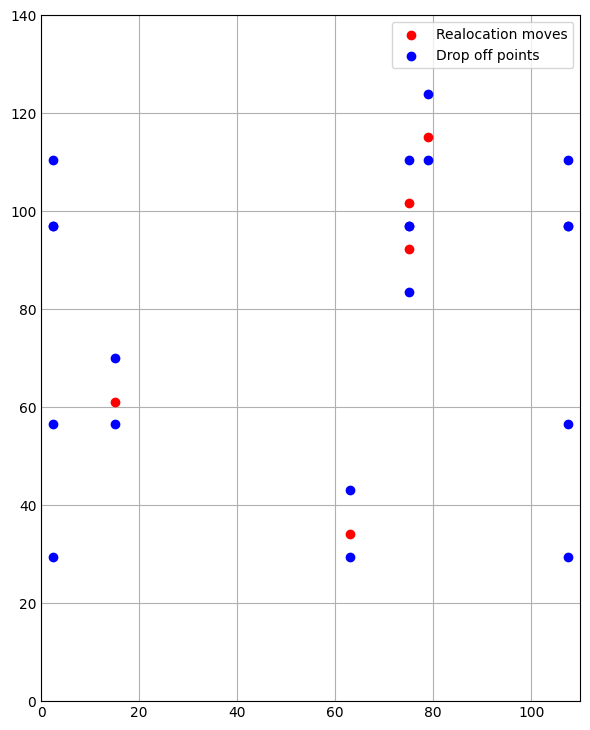

In [5]:
Simulation.plot_map(J,D,[],figsize=(5.5,7))

In [6]:
trips_problem=trptr_problem(n,m,J,D,Point(0,0),Point(0,0))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-29
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2827 rows, 312 columns and 12122 nonzeros
Model fingerprint: 0x636c56ca
Variable types: 42 continuous, 270 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 126.3779510
Presolve removed 7 rows and 7 columns
Presolve time: 0.02s
Presolved: 2820 rows, 305 columns, 12012 nonzeros
Variable types: 42 continuous, 263 integer (263 binary)

Root relaxation: objective 0.000000e+00, 90 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0    

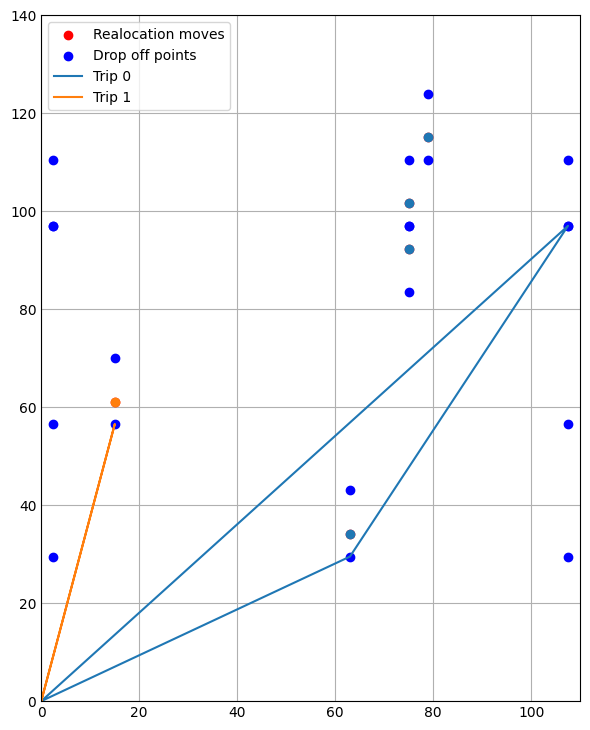

In [7]:
Simulation.plot_map(J,D,trips_problem,figsize=(5.5,7))

In [8]:
trips=Solver.sa_approach(n, m, ks, kr, kn, T_start, c, J, D, Point(0,0), Point(0,0))

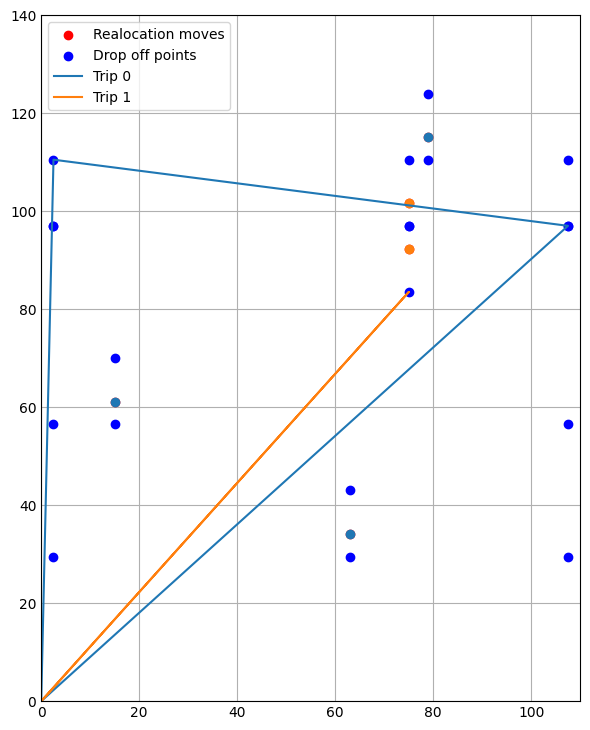

In [9]:
Simulation.plot_map(J,D,trips,figsize=(5.5,7))

In [10]:
new_trips=Solver.sm_matheuristic(J,D,trips)


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5 rows, 2 columns and 5 nonzeros
Model fingerprint: 0x0d94fdf4
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 120.5665573
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 120.567 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.205665573159e+02, best bound 1.205665573159e+02, gap 0.0000%


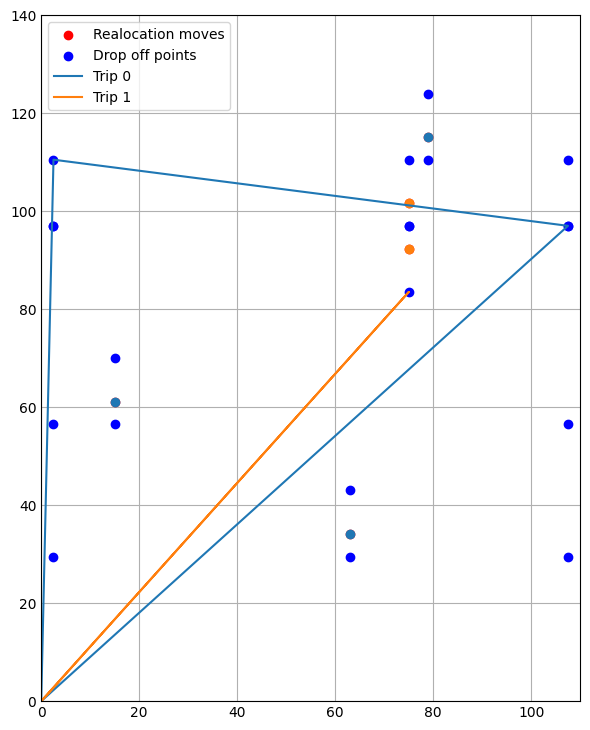

In [11]:
Simulation.plot_map(J,D,new_trips,figsize=(5.5,7))


In [12]:
trips_localsearch=Solver.local_search(new_trips,J,D,100000)

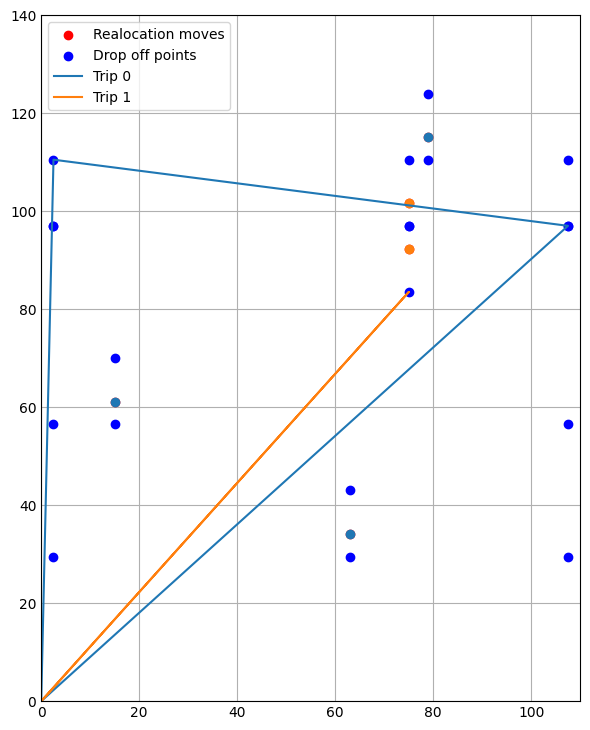

In [13]:
Simulation.plot_map(J,D,trips_localsearch,figsize=(5.5,7))


In [16]:
time_cc=Trips.get_total_duration(trips)
time_sam=Trips.get_total_duration(new_trips)
time_local_search=Trips.get_total_duration(trips_localsearch)
time_problem=Trips.get_total_duration(trips_problem)
print(f"time cc = {time_cc}")
print(f"time sam = {time_sam}")
print(f"time localsearch = {time_local_search}")
print(f'time problem={time_problem}')


time cc = 120.56655731590166
time sam = 120.56655731590166
time localsearch = 120.56655731590166
time problem=87.48622090432018
